# **Модель машинного обучения, предсказывающая отключения электроэнергии на ЛЭП**


Обеспечение надежного электроснабжения потребителей при условии поставки им качественной электрической энергии является необходимым условием эффективного развития народного хозяйства. Завышенная протяжённость, совместно с износом сетей приводит к тому, что поток отказов в них доходит до 37 год-1 на 100 км, а время восстановления – до 8 ч. Ущербы от недоотпуска электроэнергии составляют от 30 до 300 руб./кВт·ч и более. Влияет протяжённость и состояние сети и на безопасность эксплуатации. С учётом указанных выше и других проблем в электроснабжении сельских потребителей актуальными являются вопросы поиска способов прогнозирования мест, наиболее подверженных к перерывам в электроснабжении.  

**Данные** В наличии имеются данные по отключениям электроэнергии в региональных электрических сетях Орловской области за 2018 по 2021 гг. Также имееются данные по характеристикам линий электропередачи (ЛЭП).

**Цель** - разработать модель машинного обучения для прогнозирования возможных отключений электроэнергии на линиях электропередачи на основе  характеристик самих ЛЭП.

**Задачи:**

- Подготовка данных к обработке
- Исследование и обработка данных
- Удаление и создание признаков
- Корреляционный анализ
- Разбиение датасета на обучающую и тестовую выборки
- Кодирование и масштабирование признаков, при необходимости работа с дисбалансом классов
- Выбор и обучение разных моделей машинного обучения на кросс-валидации
- Выбор лучшей модели по метрике ROC-AUC на кросс-валидации
- Оценка качества лучшей модели на тестовой выборке
- Анализ других метрик, построение матрицы ошибок и  изучение важности признаков лучшей модели.
- Выводы

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as Pipeline_smote
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

!pip install phik
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

!pip install catboost
import catboost as cat
from catboost import CatBoostClassifier, Pool, cv

!pip install lightgbm
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

# Подготовка данных

## Загрузка данных

### Данные по отключениям электроэнергии 

У нас в наличии два датасета: 1. События отключения электроэнергии с 1 января 2018 по 14 октября 2021 . Вид технологического отключения: Аварийное, Неотложное, Плановое, Неплановое, Потребительское, Ограничения 2. События отключения электроэнергии с 1 января 2021 г. по 31 декабря 2022 г. Вид технологического отключения: Аварийное.

Загрузим оба датасета, изучим и конкатенируем их.

In [2]:
# Загружаем датасет с событиями отключения электроэнергии 2018 - 2021
df = pd.read_excel(open("data_outages_2018_21.xlsx", 'rb'), sheet_name='ЖурналОтключений', usecols="B:AF")

# Удаляем ненужные столбцы и строки
df = df.iloc[5:].drop([7,24666], axis=0)

# Переименовываем ячейки
df.iloc[0,19:24] = 'Количество обесточенных ' + df.iloc[1,19:24]
df.iloc[0,1:5] = df.iloc[1,1:5]

# Устанавливаем новые названия столбцов
df.columns = list(df.loc[5])
df = df.drop([5,6], axis=0)

df.head()

,№ п.п.,ДЗО,Филиал(ПО) ДЗО,ПО филиала ДЗО,РЭС,"Электросетевой объект: ЛЭП, ПС",Диспетчерское наименование,Диспетчерское наименование оборудования ПС,Напряжение сети,Дата и время возникновения события,...,"Количество обесточенных населённых пунктов (НП), шт.","Количество обесточенных населения, чел.",Количество обесточенных социально-значимых объектов,"Суммарная отключённая мощность, МВт","Длительность события, ч","Длительность перерывов электроснабжения, ч","Суммарная длительность отключений потребителей, ч (17х24)",Причина отключения,Описание работы РЗА,Причина отключения упрощ
8,1,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ-10кВ №16 ПС Приборная,NaN,10 (10.5),2018-01-06 03:03:00,...,10,779,10,0.55,0.1167,0.1167,86.2413,06.01.2018 03:03 Отлючился В-10 кВ от Т.О. АПВ...,Оценка не требуется,Токовая отсечка
9,2,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ 10кВ №37 ПС Володарская,NaN,10 (10.5),2018-01-06 09:48:00,...,29,1574,4,0.2,7.7833,0.8,1156,"9-48 Произведен осмотр КРУН-10кВ,обнаружено, ч...",Правильно,Повреждение КЛ 10 кВ
10,3,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ-10кВ №28 ПС Володарская,NaN,10 (10.5),2018-01-06 16:17:00,...,NaN,NaN,NaN,NaN,0,NaN,NaN,"16-17 Произвден осмотр КРУН-10кВ,от МТЗ отключ...",Правильно,МТЗ
11,4,ПАО «Россети Центр»,Орелэнерго,NaN,Ливенский РЭС,ВЛ,"ВЛ-0,4кВ ф-1 КТП-10/В.Д-4-160",NaN,0.38,2018-01-09 14:16:00,...,1,48,0,0.021,0.6,0.6,31.2,"Включен АВ-0,4кВ.",Оценка не требуется,Включение АВ
12,5,ПАО «Россети Центр»,Орелэнерго,NaN,Новодеревеньковский РЭС Архив,ВЛ,"ВЛ-0,4кВ КТП 1/С-1-100 Ф-1 н.п.Залесное",NaN,0.38,2018-01-10 10:03:00,...,0,0,0,0.003,3.45,3.45,193.2,Отключение по заявке,NaN,Отключение по заявке


In [3]:
# Загружаем датасет с событиями отключения электроэнергии 2021 - 2022
df2 = pd.read_excel(open("data_outages_2021_22.xlsx", 'rb'), sheet_name='ЖурналОтключений', usecols="B:AB")

# Удаляем ненужные столбцы и строки
df2 = df2.iloc[6:].drop([8,5683], axis=0)

# Переименовываем ячейки
df2.iloc[0,16:21] = 'Количество обесточенных ' + df2.iloc[1,16:21]
df2.iloc[0,1:5] = df2.iloc[1,1:5]

# Устанавливаем новые названия столбцов
df2.columns = list(df2.loc[6])
df2 = df2.drop([6,7], axis=0)

df.head()

,№ п.п.,ДЗО,Филиал(ПО) ДЗО,ПО филиала ДЗО,РЭС,"Электросетевой объект: ЛЭП, ПС",Диспетчерское наименование,Диспетчерское наименование оборудования ПС,Напряжение сети,Дата и время возникновения события,...,"Количество обесточенных населённых пунктов (НП), шт.","Количество обесточенных населения, чел.",Количество обесточенных социально-значимых объектов,"Суммарная отключённая мощность, МВт","Длительность события, ч","Длительность перерывов электроснабжения, ч","Суммарная длительность отключений потребителей, ч (17х24)",Причина отключения,Описание работы РЗА,Причина отключения упрощ
8,1,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ-10кВ №16 ПС Приборная,NaN,10 (10.5),2018-01-06 03:03:00,...,10,779,10,0.55,0.1167,0.1167,86.2413,06.01.2018 03:03 Отлючился В-10 кВ от Т.О. АПВ...,Оценка не требуется,Токовая отсечка
9,2,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ 10кВ №37 ПС Володарская,NaN,10 (10.5),2018-01-06 09:48:00,...,29,1574,4,0.2,7.7833,0.8,1156,"9-48 Произведен осмотр КРУН-10кВ,обнаружено, ч...",Правильно,Повреждение КЛ 10 кВ
10,3,ПАО «Россети Центр»,Орелэнерго,NaN,Орловский РЭС,ВЛ,ВЛ-10кВ №28 ПС Володарская,NaN,10 (10.5),2018-01-06 16:17:00,...,NaN,NaN,NaN,NaN,0,NaN,NaN,"16-17 Произвден осмотр КРУН-10кВ,от МТЗ отключ...",Правильно,МТЗ
11,4,ПАО «Россети Центр»,Орелэнерго,NaN,Ливенский РЭС,ВЛ,"ВЛ-0,4кВ ф-1 КТП-10/В.Д-4-160",NaN,0.38,2018-01-09 14:16:00,...,1,48,0,0.021,0.6,0.6,31.2,"Включен АВ-0,4кВ.",Оценка не требуется,Включение АВ
12,5,ПАО «Россети Центр»,Орелэнерго,NaN,Новодеревеньковский РЭС Архив,ВЛ,"ВЛ-0,4кВ КТП 1/С-1-100 Ф-1 н.п.Залесное",NaN,0.38,2018-01-10 10:03:00,...,0,0,0,0.003,3.45,3.45,193.2,Отключение по заявке,NaN,Отключение по заявке


In [4]:
print('Размеры датасета df1:',
      '\n  Количество событий -', df.shape[0],
      '\n  Количество столбцов -', df.shape[1])
print()
print('Размеры датасета df2:',
      '\n  Количество событий -', df2.shape[0],
      '\n  Количество столбцов -', df2.shape[1])

Размеры датасета df1: 
  Количество событий - 24658 
  Количество столбцов - 31

Размеры датасета df2: 
  Количество событий - 5674 
  Количество столбцов - 27


Изучая размеры датасета видно, что количество событий в датасете df1 больше, чем в df2. Это обяснимо тем, что в первом датасете собрана информация за 4 года, тогда как во втором- только за 2. При этом в датасете df2 рассмотрены только аварийный вид технологического отвлючения. Количество столцов, содержащих информацию о событиях, также разнится. Изучим имеющиеся столбцы:

Изучим имеющиеся столбцы:

In [5]:
print('df: \n',df.columns)
print('df2: \n',df2.columns)

df: 
 Index(['№ п.п.', 'ДЗО', 'Филиал(ПО) ДЗО', 'ПО филиала ДЗО', 'РЭС',
       'Электросетевой объект: ЛЭП, ПС', 'Диспетчерское наименование',
       'Диспетчерское наименование оборудования ПС', 'Напряжение сети',
       'Дата и время возникновения события', 'Год', 'Месяц', 'Час',
       'Вид технологического отключения', 'АПВ', 'РПВ',
       'Дата и время прекращения электроснабжения потребителей',
       'Дата и время восстановления электроснабжения потребителям',
       'Дата и время восстановления нормальной(доаварийной) схемы',
       'Количество обесточенных потребителей (точек поставки), ед.',
       'Количество обесточенных трансформаторных подстанций (ТП), шт.',
       'Количество обесточенных населённых пунктов (НП), шт.',
       'Количество обесточенных населения, чел.',
       'Количество обесточенных социально-значимых объектов',
       'Суммарная отключённая мощность, МВт', 'Длительность события, ч',
       'Длительность перерывов электроснабжения, ч',
       'Суммарная

In [6]:
# Проверим количество столбцов
print('Количество столбцов:', 'df -', len(df.columns), '; df2 -', len(df2.columns))
print('Недостающие столбцы:',[col for col in df.columns if col not in df2.columns])

Количество столбцов: df - 31 ; df2 - 27
Недостающие столбцы: ['Год', 'Месяц', 'Час', 'Причина отключения упрощ']


Таким образом, видно во втором датасете отсутствует столбцы 'Год', 'Месяц', 'Час', 'Причина отключения упрощ'. Столбцы 'Год', 'Месяц', 'Час' будут полезны для дальнейшего анализа, поэтому выведем их из столбца 'Дата и время возникновения события':

In [7]:
# Создадим в датасете df2 столбцы: 'Год', 'Месяц', 'Час'
df2['Год'] = pd.DatetimeIndex(df2['Дата и время возникновения события']).year
df2['Месяц'] = pd.DatetimeIndex(df2['Дата и время возникновения события']).month
df2['Час'] = pd.DatetimeIndex(df2['Дата и время возникновения события']).hour

Столбец 'Причина отключения упрощ' в df1 рекомендуется удалить, так как предварительная проверка показала, что данные вносились разными людьми без определенной методики. Поэтому имеется множетство неточностей, ошибок, разного представления одних и тех же причин аварий, что повышает кардинальность признака и приводит к сомнению об точности предоставленных данных. 

In [8]:
df = df.drop('Причина отключения упрощ', axis=1)

При объеденении таблиц нужно учесть, что в обе таблицы входят данные за 2021 год.

In [9]:
print('Последние данные в таблице df датируются', 
      df['Дата и время возникновения события'].max().month,'-ым месяцем',
      df['Дата и время возникновения события'].max().year)
print('Первые данные в таблице df2 датируются', 
      df2['Дата и время возникновения события'].min().month,'-ым месяцем',
      df2['Дата и время возникновения события'].min().year)

Последние данные в таблице df датируются 10 -ым месяцем 2021
Первые данные в таблице df2 датируются 1 -ым месяцем 2021


In [10]:
# Конкатерируем таблицы
df_18_22 = pd.concat([df, df2])

# Удалим дупликаты
df_18_22.drop_duplicates(subset=['Дата и время возникновения события',
                                 'Диспетчерское наименование', 
                                 'Причина отключения'],
                         inplace=True, ignore_index=True)

print('Количество строк в объединенном датасете -', df_18_22.shape[0])

Количество строк в объединенном датасете - 28455


### Данные об ВЛ

Загрузим датасет с информацией о ВЛ 35 кВ

In [11]:
# Загружаем датасет с информацией о ВЛ 110 кВ
df_35_inf = pd.read_excel(open("ВЛ_КЛ_35-110_31.xlsx", 'rb'), sheet_name='Вл 35 кВ', nrows=147)


# Установим названия столбцов
df_35_inf.columns = list(df_35_inf.loc[27])

# Удалим лишние строки
df_35_inf.drop(labels=list(range(28)), axis = 0, inplace=True)

# Переменуем название технического места в диспетчерское наименование
df_35_inf = df_35_inf.rename(columns = {'Название технического места':'Диспетчерское наименование'})

#  Установим новый индекс
df_35_inf.reset_index(drop=True,inplace=True)

print(df_35_inf.shape)
df_35_inf.sample(5)

(118, 19)


,Индекс состояния,Диспетчерское наименование,"Проводник, тип, сечение",ТИП,В эксплуатации с года,"Срок эксплуатации, лет",По цепям,По трассе,Протяженность возд. участков,Длина кабельных\n участков,Нормативный срок службы,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту,Класс напряжения
0,68,ВЛ 35 кВ Кромская - Кутафино №2,АС-70,ВЛ,2011,11,14.787,14.787,"14,787 км",0,35 Год,2.778,0.435,76,23,0,0,Транзитная,"35,0 кВ"
15,88,ВЛ 35 кВ Советская - Биофабрика I цепь,АС-70,ВЛ,1966,56,4.528,4.528,"4,528 км",0,35 Год,1.69,1.023,41,0,0,0,Транзитная,"35,0 кВ"
16,93,ВЛ 35 кВ Советская - Биофабрика II цепь,АС-70,ВЛ,1986,36,4.706,3.609,"4,706 км",0,35 Год,1.128,0.742,31,1,0,0,Транзитная,"35,0 кВ"
35,79,ВЛ 35 кВ Сеньково - Нижняя Слобода,АСу-70,ВЛ,1987,35,14.186,4.932,"14,186 км",0,35 Год,1.55,0,49,0,0,0,Транзитная,"35,0 кВ"
37,89,ВЛ 35 кВ Малоархангельская110-Куракинска,АС-70,ВЛ,1961,61,25.766,10.89,"25,766 км",0,35 Год,2.922,0,98,0,0,0,Транзитная,"35,0 кВ"


Загрузим датасет с информацией о ВЛ 110 кВ

In [12]:
# Загружаем датасет с информацией о ВЛ 110 кВ
df_110_inf = pd.read_excel(open("ВЛ_КЛ_35-110_31.xlsx", 'rb'), sheet_name='Sheet1', nrows=75)


# Удалим пропуски, появившиеся из-за объединенных ячеек. Для этого:
# Заполним пропуски в стоблце 'Название технического места':
df_110_inf['Название технического места'] = df_110_inf['Название технического места'].fillna(method='ffill')

# Заменим значения  протяженности ЛЭП по цепям на сумму длин ЛЭП, представленных разными проводами.
df_110_inf = df_110_inf.merge(df_110_inf.groupby('Название технического места')['По цепям'].sum(),
                 on='Название технического места', 
                 suffixes=('', '_sum'))

df_110_inf = df_110_inf.drop('По цепям', axis=1)
df_110_inf = df_110_inf.rename(columns={'По цепям_sum': 'По цепям'})

# Удалим  пропуски
df_110_inf = df_110_inf.dropna(subset='ТИП')

# Переменуем название технического места в диспетчерское наименование
df_110_inf = df_110_inf.rename(columns = {'Название технического места':'Диспетчерское наименование'})

#  Установим новый индекс
df_110_inf.reset_index(drop=True,inplace=True)

print(df_110_inf.shape)
df_110_inf.sample(5)

(66, 19)


,Индекс состояния,Диспетчерское наименование,"Проводник, тип, сечение",ТИП,В эксплуатации с года,"Срок эксплуатации, лет",По трассе,Протяженность возд. участков,Длина кабельных\n участков,Нормативный срок службы,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту,Класс напряжения,По цепям
34,73.0,ВЛ 110 кВ Железногорская – Дмитровская,АС-120,ВЛ,1971.0,51.0,26.200,"26,400 км",0.0,35 Год,15.800,0.600,126.0,6.0,0.0,0.0,Транзитная,"110,0 кВ",26.400
59,62.0,ВЛ 110 кВ Ливны - Покровская с отпайками,АС-120,ВЛ,1978.0,44.0,79.318,"79,318 км",0.0,35 Год,18.804,0.000,334.0,55.0,0.0,0.0,Не транзитная,"110,0 кВ",79.318
9,77.0,ВЛ 110 кВ Орл. ТЭЦ – Орл. Район.№3 с отп,АС-185,ВЛ,1957.0,65.0,5.915,"24,885 км",0.0,35 Год,8.138,0.000,27.0,7.0,0.0,0.0,Транзитная,"110,0 кВ",24.885
47,96.0,ВЛ 110 кВ Чернь - Плавск с отпайкой,АС-120,ВЛ,1959.0,63.0,0.080,"23,586 км",0.0,35 Год,7.356,2.409,0.0,1.0,0.0,0.0,Транзитная,"110,0 кВ",23.586
62,100.0,ВЛ 110 кВ Орл. Районная-Северная I цепь,АС-185,ВЛ,2006.0,16.0,8.537,"8,537 км",0.0,35 Год,7.162,0.141,26.0,25.0,0.0,0.0,Не транзитная,"110,0 кВ",8.537


Создадим датасет с информацией об аварийных событиях на ВЛ 35 кВ из таблицы df_18_22: 

In [13]:
df_35 = df_18_22[(df_18_22['Напряжение сети']=='35') & (df_18_22['Вид технологического отключения']=='Аварийное')]
df_35.shape

(54, 30)

Создадим датасет с информацией об аварийных событиях на ВЛ 110 кВ из таблицы df_18_22: 

In [14]:
df_110 = df_18_22[(df_18_22['Напряжение сети']=='110') & (df_18_22['Вид технологического отключения']=='Аварийное')]
df_110.shape

(289, 30)

Cоединим датасеты:

In [15]:
df_35_joint = df_35_inf.merge(df_35, on='Диспетчерское наименование', how='left')

df_110_joint = df_110_inf.merge(df_110, on='Диспетчерское наименование', how='left')

Несмотря на то, что в наличии имеется информация по ВЛ 35 и 110 кВ, для решения поставленной цели, будем работать только с сетями 110 кВ из-за наличия большего количества объектов для обучения моделей. 

## Обработка данных

### 110 кВ 

Сгрупируем таблицы так,чтобы на каждую ЛЭП по годам были посчитаны количество отключений и продолжительность этих отключений.

In [16]:
#Создадим временный признак факт отключения электроэнергии
df_110_joint['Факт_отключения'] = df_110_joint['ДЗО'].where(df_110_joint['ДЗО'].isna(), 1)
df_110_joint['Факт_отключения'] = df_110_joint['Факт_отключения'].fillna(0)

# Заполним год возникновения события датой 2022. Это пригодится при групировке.
df_110_joint['Год'] = df_110_joint['Год'].fillna(2022)

In [17]:
# Сгрупируем таблицу

ML_df_110 = df_110_joint.groupby(['Диспетчерское наименование', 'Год'],as_index=False)[['Факт_отключения','Длительность события, ч']].sum()

ML_df_110 = ML_df_110.rename(columns={'Факт_отключения': 'Количество отключений',
                                      'Длительность события, ч': 'Продолжительность отключений'})


# Добавим столбец, указывающий были ли отключения в определенном году на определенной ЛЭП
ML_df_110['Факт отключения'] = ML_df_110['Количество отключений'].apply(lambda x: 'Yes' if x>0 else 'No')

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (154, 5)


,Диспетчерское наименование,Год,Количество отключений,Продолжительность отключений,Факт отключения
0,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2022,1,3.8667,Yes
1,ВЛ 110 кВ Богородицкая – Аксинино,2018,1,0.85,Yes
2,ВЛ 110 кВ Богородицкая – Аксинино,2019,5,83.4167,Yes
3,ВЛ 110 кВ Богородицкая – Аксинино,2020,1,0.8833,Yes
4,ВЛ 110 кВ Богородицкая – Аксинино,2022,1,0.6667,Yes


В данной таблице представлены только те года, в которые происходили отключения (Данные доступны за 2018-2022). Года, в которые не были зафиксированы перерывы в электроснабжении, не учтены. Добавим их:

In [18]:
years = pd.Series([2018, 2019, 2020, 2021, 2022])

for i in ML_df_110['Диспетчерское наименование'].unique():
    for j in years[~years.isin(ML_df_110[ML_df_110['Диспетчерское наименование']== i]['Год'])]:
        ML_df_110.loc[ML_df_110.shape[0], ['Диспетчерское наименование', 'Год']] = [i, j]
        
ML_df_110[['Количество отключений',
           'Продолжительность отключений']
         ] = ML_df_110[['Количество отключений', 
                        'Продолжительность отключений']
                      ].fillna(0)
        
ML_df_110['Факт отключения'] = ML_df_110['Факт отключения'].fillna('No')

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.sample(5)

Размер таблицы: (330, 5)


,Диспетчерское наименование,Год,Количество отключений,Продолжительность отключений,Факт отключения
152,КВЛ 110 кВ Ливенская ТЭЦ-Ливны IIц с отп,2022.0,0.0,0.0000,No
218,ВЛ 110 кВ Мценск – МЛЗ II цепь,2020.0,0.0,0.0000,No
195,ВЛ 110 кВ Ливны – Верховье II II ц с отп,2022.0,0.0,0.0000,No
88,ВЛ 110 кВ Нарышкинская – Богородицкая,2021.0,1.0,0.2333,Yes
280,ВЛ 110 кВ Узловая - Орл. Районная с отп.,2021.0,0.0,0.0000,No


Добавим информацию по ЛЭП из df_110_joint:

In [19]:
ML_df_110 = ML_df_110.merge(df_110_joint[['Диспетчерское наименование',
                                          'Индекс состояния', 
                                          'Проводник, тип, сечение', 
                                          'ТИП', 'Срок эксплуатации, лет',
                                          'В эксплуатации с года',                                          
                                          'По цепям', 
                                          'По трассе', 
                                          'Протяженность возд. участков',
                                          'Длина кабельных\n участков', 
                                          'Протяженность по лесу',
                                          'Протяженность по населенной местности, км',
                                          'ЖБ Опоры', 
                                          'Металлические опоры',
                                          'Чистое дерево',
                                          'На ЖБ пасынках', 
                                          'Отношение ЛЭП к транзиту',
                                          ]],
                            on='Диспетчерское наименование',
                            suffixes=(False, False)                            
                           ).drop_duplicates(subset=['Диспетчерское наименование', 
                                                     'Год'])

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (330, 21)


,Диспетчерское наименование,Год,Количество отключений,Продолжительность отключений,Факт отключения,Индекс состояния,"Проводник, тип, сечение",ТИП,"Срок эксплуатации, лет",В эксплуатации с года,...,По трассе,Протяженность возд. участков,Длина кабельных\n участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту
0,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2022.0,1.0,3.8667,Yes,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
1,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2018.0,0.0,0.0000,No,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
2,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2019.0,0.0,0.0000,No,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
3,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2020.0,0.0,0.0000,No,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
4,ВЛ 110 кВ Аксинино - Шаблыкино (92-166),2021.0,0.0,0.0000,No,79.0,АС-95,ВЛ,41.0,1981.0,...,13.05,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная


Так как срок эксплуатации ЛЭП в датасет df_110_inf вносился в момент его выгрузки (2022), а отключения электроэнергии фиксировались в течении 2018-2021, то признак "срок эксплуатации ЛЭП" содержит не  совсем точную информацию. Подправим эти данные:

In [20]:
ML_df_110[['Год',
           'В эксплуатации с года',
           'Срок эксплуатации, лет',           
          ]] = ML_df_110[['Год',
                          'В эксплуатации с года',
                          'Срок эксплуатации, лет'                          
                         ]].astype(int, errors='ignore')

ML_df_110['Срок эксплуатации, лет'
         ] = ML_df_110['Срок эксплуатации, лет'
                      ].where(ML_df_110['Год'].isna(),
                              ML_df_110['Год'] - ML_df_110['В эксплуатации с года'])

Удалим ненужные столбцы:

In [21]:
ML_df_110 = ML_df_110.drop(['Диспетчерское наименование',
                            'Год', 
                            'В эксплуатации с года',
                            'По цепям', 
                            'По трассе',
                            'Количество отключений',
                            'Продолжительность отключений'
                            ],
                           axis=1)

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (330, 14)


,Факт отключения,Индекс состояния,"Проводник, тип, сечение",ТИП,"Срок эксплуатации, лет",Протяженность возд. участков,Длина кабельных\n участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту
0,Yes,79.0,АС-95,ВЛ,41,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
1,No,79.0,АС-95,ВЛ,37,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
2,No,79.0,АС-95,ВЛ,38,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
3,No,79.0,АС-95,ВЛ,39,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная
4,No,79.0,АС-95,ВЛ,40,"13,050 км",0.0,6.612,1.392,74.0,1.0,0.0,0.0,Транзитная


Проверим пропуски:

In [22]:
print('Количество провусков:', ML_df_110.isna().sum().sum())

Количество провусков: 0


Заменим типы данных:

In [23]:
ML_df_110[['Индекс состояния', 'ЖБ Опоры', 'Металлические опоры', 
           'Чистое дерево', 'На ЖБ пасынках']
         ] = ML_df_110[['Индекс состояния','ЖБ Опоры', 'Металлические опоры', 
                              'Чистое дерево', 'На ЖБ пасынках']
                      ].astype(int)

ML_df_110['Протяженность возд. участков'
             ] = ML_df_110['Протяженность возд. участков'
                              ].apply(lambda x: re.sub('[ км]', '', x))
ML_df_110['Протяженность возд. участков'
             ] = ML_df_110['Протяженность возд. участков'
                              ].apply(lambda x: re.sub(',', '.', x))
ML_df_110['Протяженность возд. участков'
             ] = ML_df_110['Протяженность возд. участков'
                              ].astype(float)

ML_df_110.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 1254
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Факт отключения                            330 non-null    object 
 1   Индекс состояния                           330 non-null    int32  
 2   Проводник, тип, сечение                    330 non-null    object 
 3   ТИП                                        330 non-null    object 
 4   Срок эксплуатации, лет                     330 non-null    int32  
 5   Протяженность возд. участков               330 non-null    float64
 6   Длина кабельных
 участков                  330 non-null    float64
 7   Протяженность по лесу                      330 non-null    float64
 8   Протяженность по населенной местности, км  330 non-null    float64
 9   ЖБ Опоры                                   330 non-null    int32  
 10  Металлические опоры           

Создадим синтетический признак, показывающий вышла ли ЛЭП за установленный нормативный срок службы (35 лет). Значение выше единицы будет показывать, что срок фактической эксплуатации превышает нормативный, ниже - не превышает.

In [24]:
ML_df_110['Переэксплуатация'] = ML_df_110['Срок эксплуатации, лет'] / 35

ML_df_110 = ML_df_110.drop('Срок эксплуатации, лет', axis=1)

ML_df_110.head()

,Факт отключения,Индекс состояния,"Проводник, тип, сечение",ТИП,Протяженность возд. участков,Длина кабельных\n участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Чистое дерево,На ЖБ пасынках,Отношение ЛЭП к транзиту,Переэксплуатация
0,Yes,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.171429
1,No,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.057143
2,No,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.085714
3,No,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.114286
4,No,79,АС-95,ВЛ,13.05,0.0,6.612,1.392,74,1,0,0,Транзитная,1.142857


### Краткий анализ признаков

Рассмотрим распределение категориальных признаков:

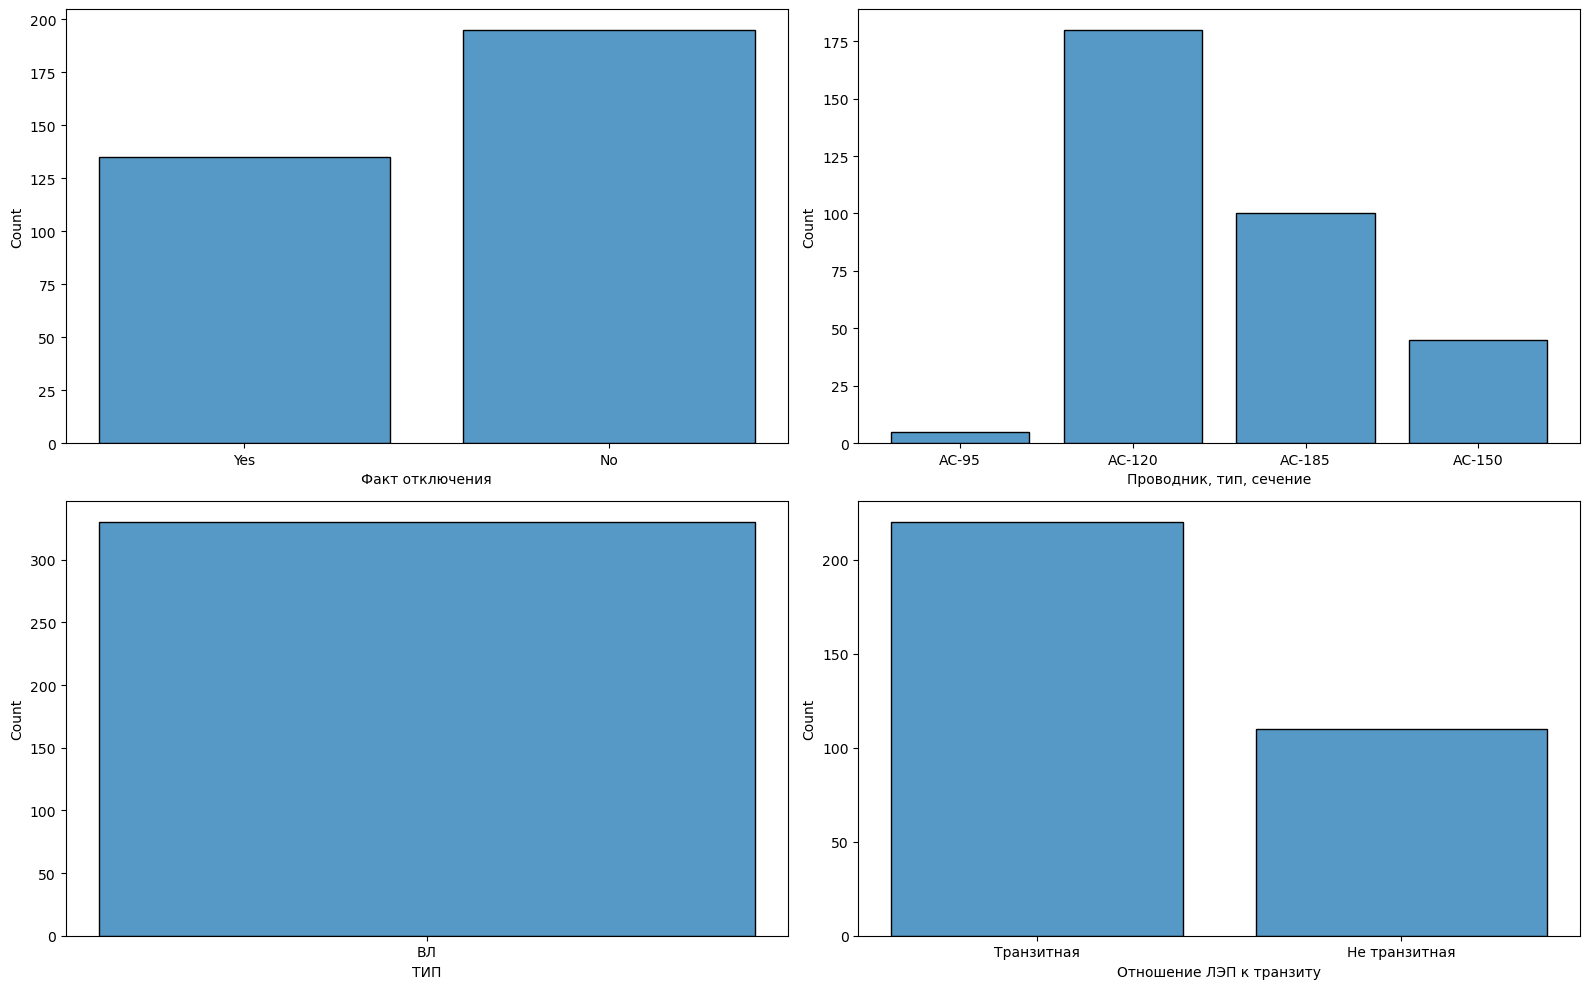

In [25]:
col_list = ML_df_110.select_dtypes(include='object').columns.tolist()

pic_box = plt.figure(figsize=(16,10))

for i in range(len(ML_df_110.select_dtypes(include='object').columns.tolist())):
    pic_box.add_subplot(2,2,i+1)
    sns.histplot(data=ML_df_110, x=col_list[i], multiple='dodge', shrink = 0.8)
plt.tight_layout() 

Из полученных диаграмм видно, что целевой признак "Факт отключения" немного не сбалансирован, в дальнейшем проверим повышение качества модели за счет борьбы с дисбалансом. Также видно, что признак "Тип" представлен только одним значением, поэтому он не будет оказывать влияние на решение моделей, удалим его. 

Рассмотрим распределение признаков с количественными значениями:


Индекс состояния :



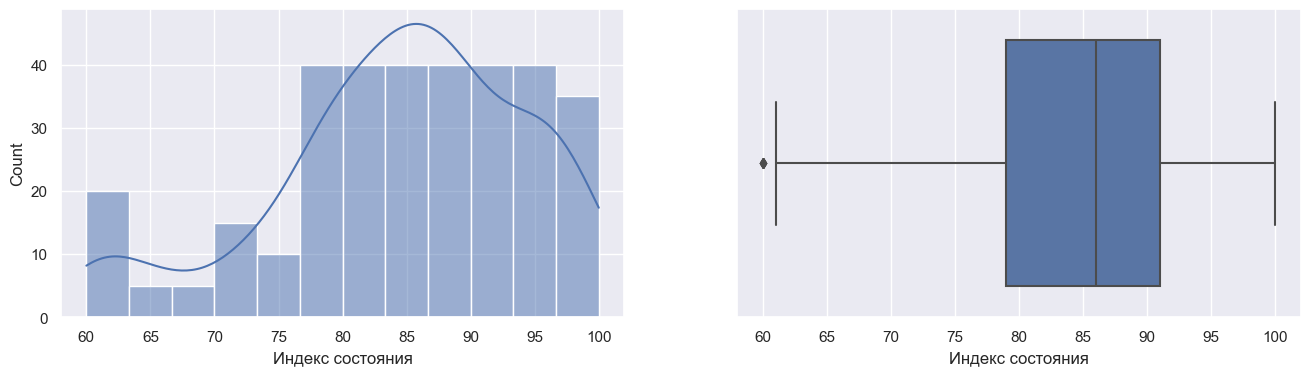


Протяженность возд. участков :



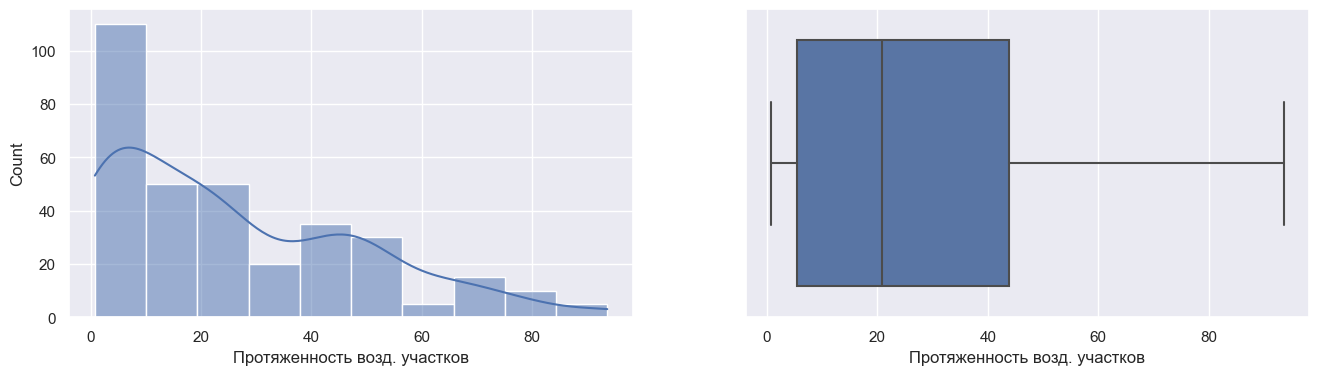


Длина кабельных
 участков :



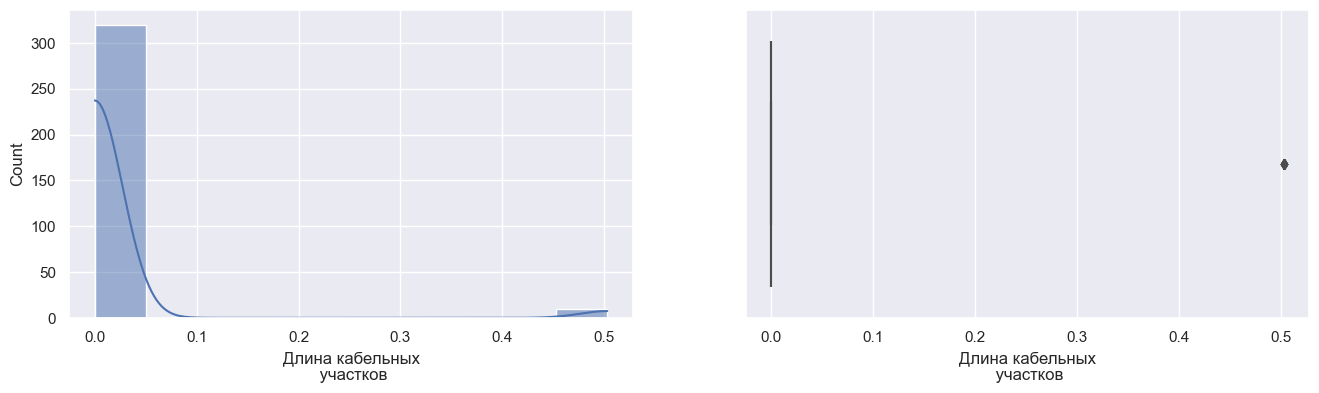


Протяженность по лесу :



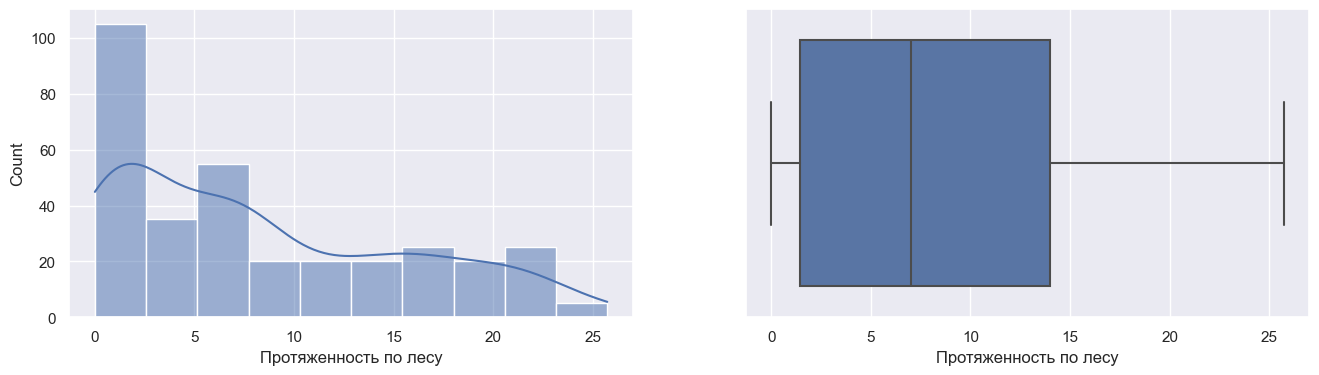


Протяженность по населенной местности, км :



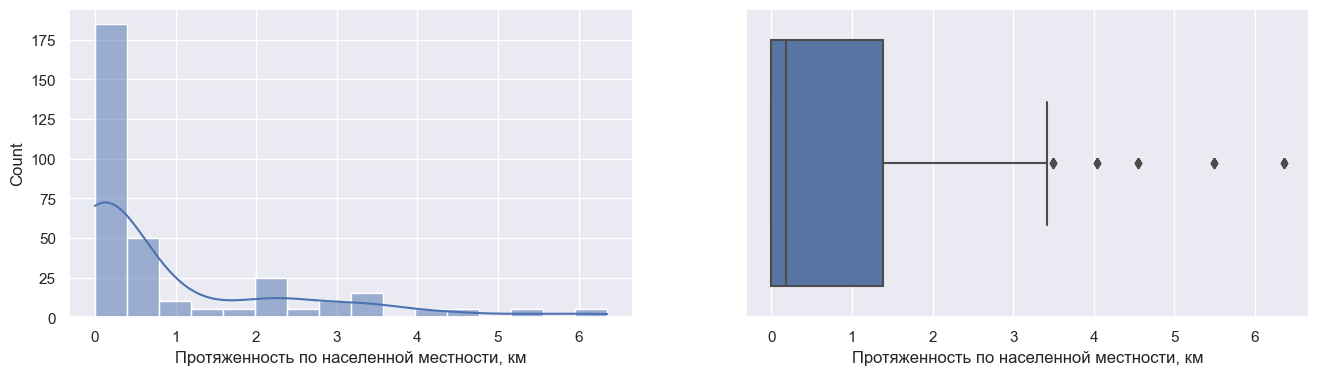


ЖБ Опоры :



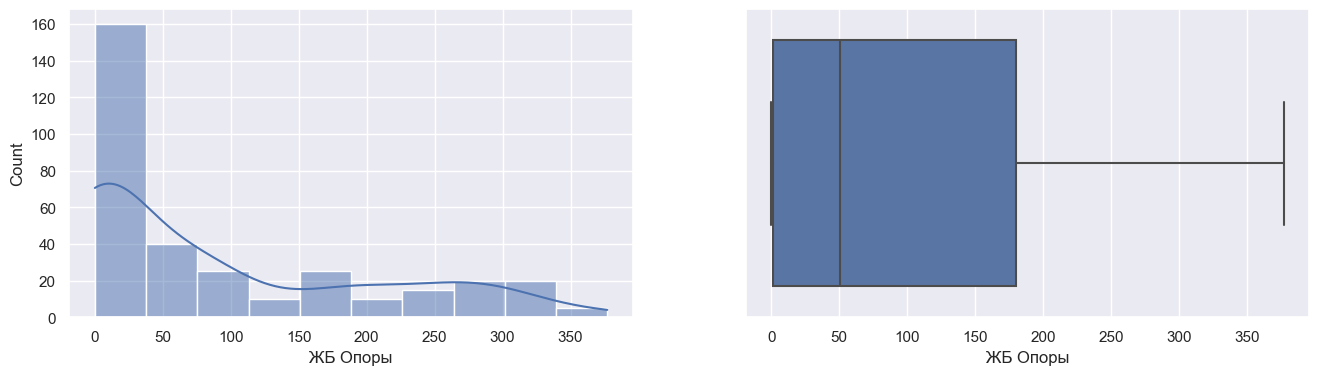


Металлические опоры :



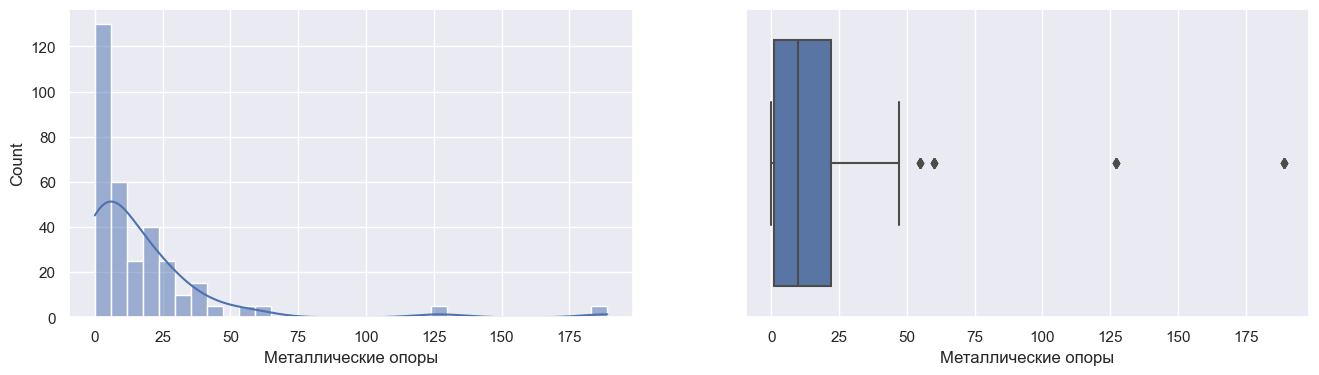


Чистое дерево :



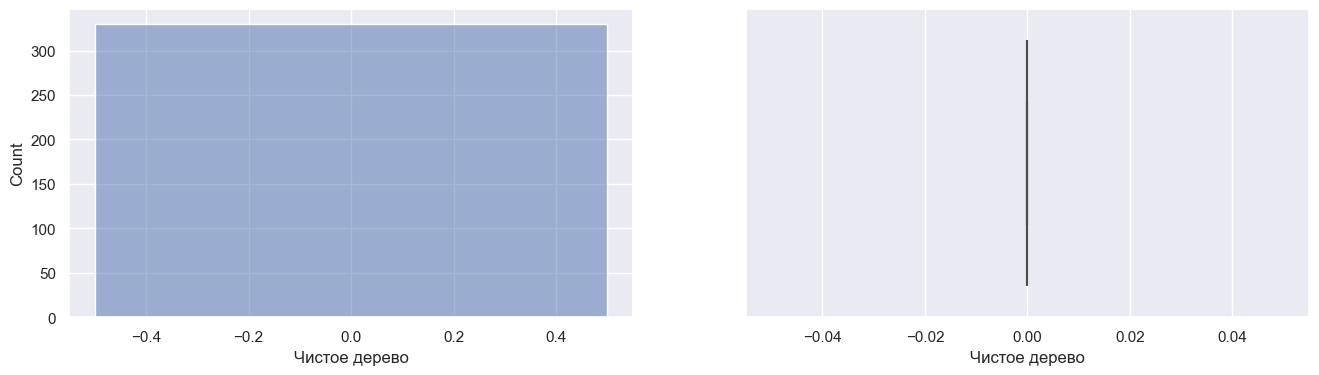


На ЖБ пасынках :



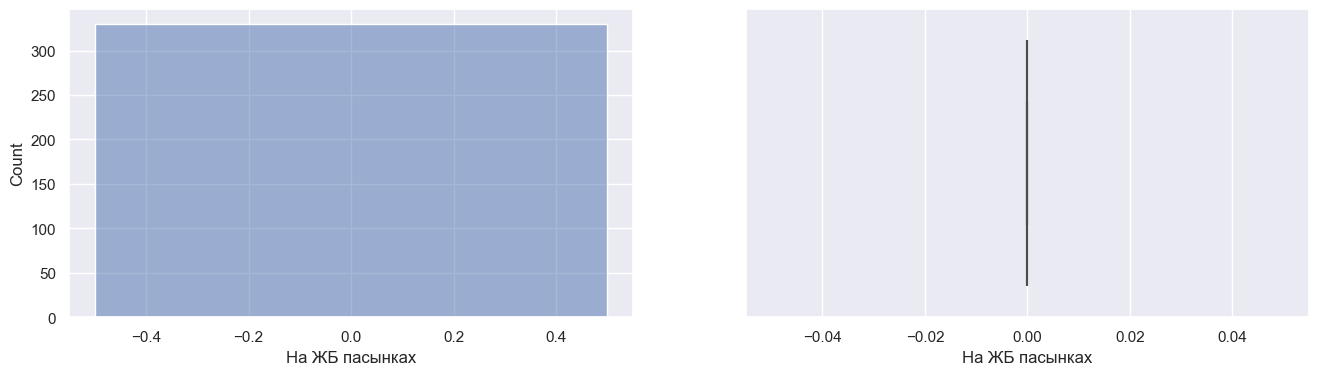


Переэксплуатация :



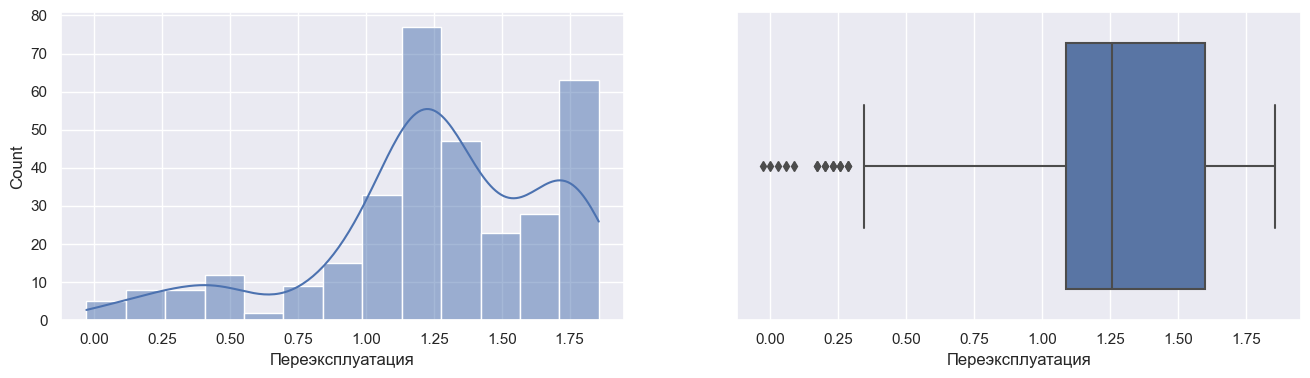

In [26]:
def analysis_quantitatives(features_list):
    for i in features_list:
        print()
        print('\033[1m' + i,':' +'\033[0m')
        print()
        sns.set()
        lines, axes = plt.subplots(1, 2, figsize=(16, 4))
        sns.histplot(data=ML_df_110, x=i, ax=axes[0], kde=True)
        sns.boxplot(data=ML_df_110, x=i, ax=axes[1])
        plt.show()
        
analysis_quantitatives(ML_df_110.select_dtypes(include=[np.number]).columns.tolist())

Признак 'Длина кабельных\n участков' распределен крайне неравномерно, что объяснимио малым количестовм значений в столбюце. /Рекомендуется не использовать этот признак для поставленной задачи. Признаки 'Чистое дерево', 'На ЖБ пасынках' рекомендуется удалить , так как они не имеют каких либо значений.

In [27]:
ML_df_110 = ML_df_110.drop(['Длина кабельных\n участков','Чистое дерево', 'На ЖБ пасынках','ТИП'], axis=1)
ML_df_110.columns

Index(['Факт отключения', 'Индекс состояния', 'Проводник, тип, сечение',
       'Протяженность возд. участков', 'Протяженность по лесу',
       'Протяженность по населенной местности, км', 'ЖБ Опоры',
       'Металлические опоры', 'Отношение ЛЭП к транзиту', 'Переэксплуатация'],
      dtype='object')

## Проверка корреляции признаков

Проверку корреляций проведем с помощью библиотеки phik. Построим матрицу корреляции признаков:

In [28]:
phik_overview = ML_df_110.phik_matrix(interval_cols=['Индекс состояния',                                                             
                                                     'Протяженность возд. участков', 
                                                     'Протяженность по лесу',
                                                     'Протяженность по населенной местности, км',
                                                     'ЖБ Опоры',
                                                     'Металлические опоры', 
                                                     'Переэксплуатация'                                                     
                                                     ])

In [29]:
phik_overview.sort_values(by='Факт отключения', 
                          ascending=False).style.background_gradient(cmap = 'coolwarm')

,Факт отключения,Индекс состояния,"Проводник, тип, сечение",Протяженность возд. участков,Протяженность по лесу,"Протяженность по населенной местности, км",ЖБ Опоры,Металлические опоры,Отношение ЛЭП к транзиту,Переэксплуатация
Факт отключения,1.000000,0.218607,0.114290,0.609221,0.605975,0.303234,0.418199,0.283970,0.381691,0.342636
Протяженность возд. участков,0.609221,0.644637,0.445997,1.000000,0.953175,0.846990,0.957536,0.647885,0.602184,0.752606
Протяженность по лесу,0.605975,0.688645,0.463345,0.953175,1.000000,0.850013,0.919901,0.636659,0.476099,0.717037
ЖБ Опоры,0.418199,0.647136,0.507600,0.957536,0.919901,0.870305,1.000000,0.629968,0.373570,0.747097
Отношение ЛЭП к транзиту,0.381691,0.531918,0.369617,0.602184,0.476099,0.405832,0.373570,0.294370,1.000000,0.858655
Переэксплуатация,0.342636,0.620365,0.517958,0.752606,0.717037,0.623796,0.747097,0.716422,0.858655,1.000000
"Протяженность по населенной местности, км",0.303234,0.602650,0.637354,0.846990,0.850013,1.000000,0.870305,0.454747,0.405832,0.623796
Металлические опоры,0.283970,0.504657,0.232249,0.647885,0.636659,0.454747,0.629968,1.000000,0.294370,0.716422
Индекс состояния,0.218607,1.000000,0.450092,0.644637,0.688645,0.602650,0.647136,0.504657,0.531918,0.620365
"Проводник, тип, сечение",0.114290,0.450092,1.000000,0.445997,0.463345,0.637354,0.507600,0.232249,0.369617,0.517958


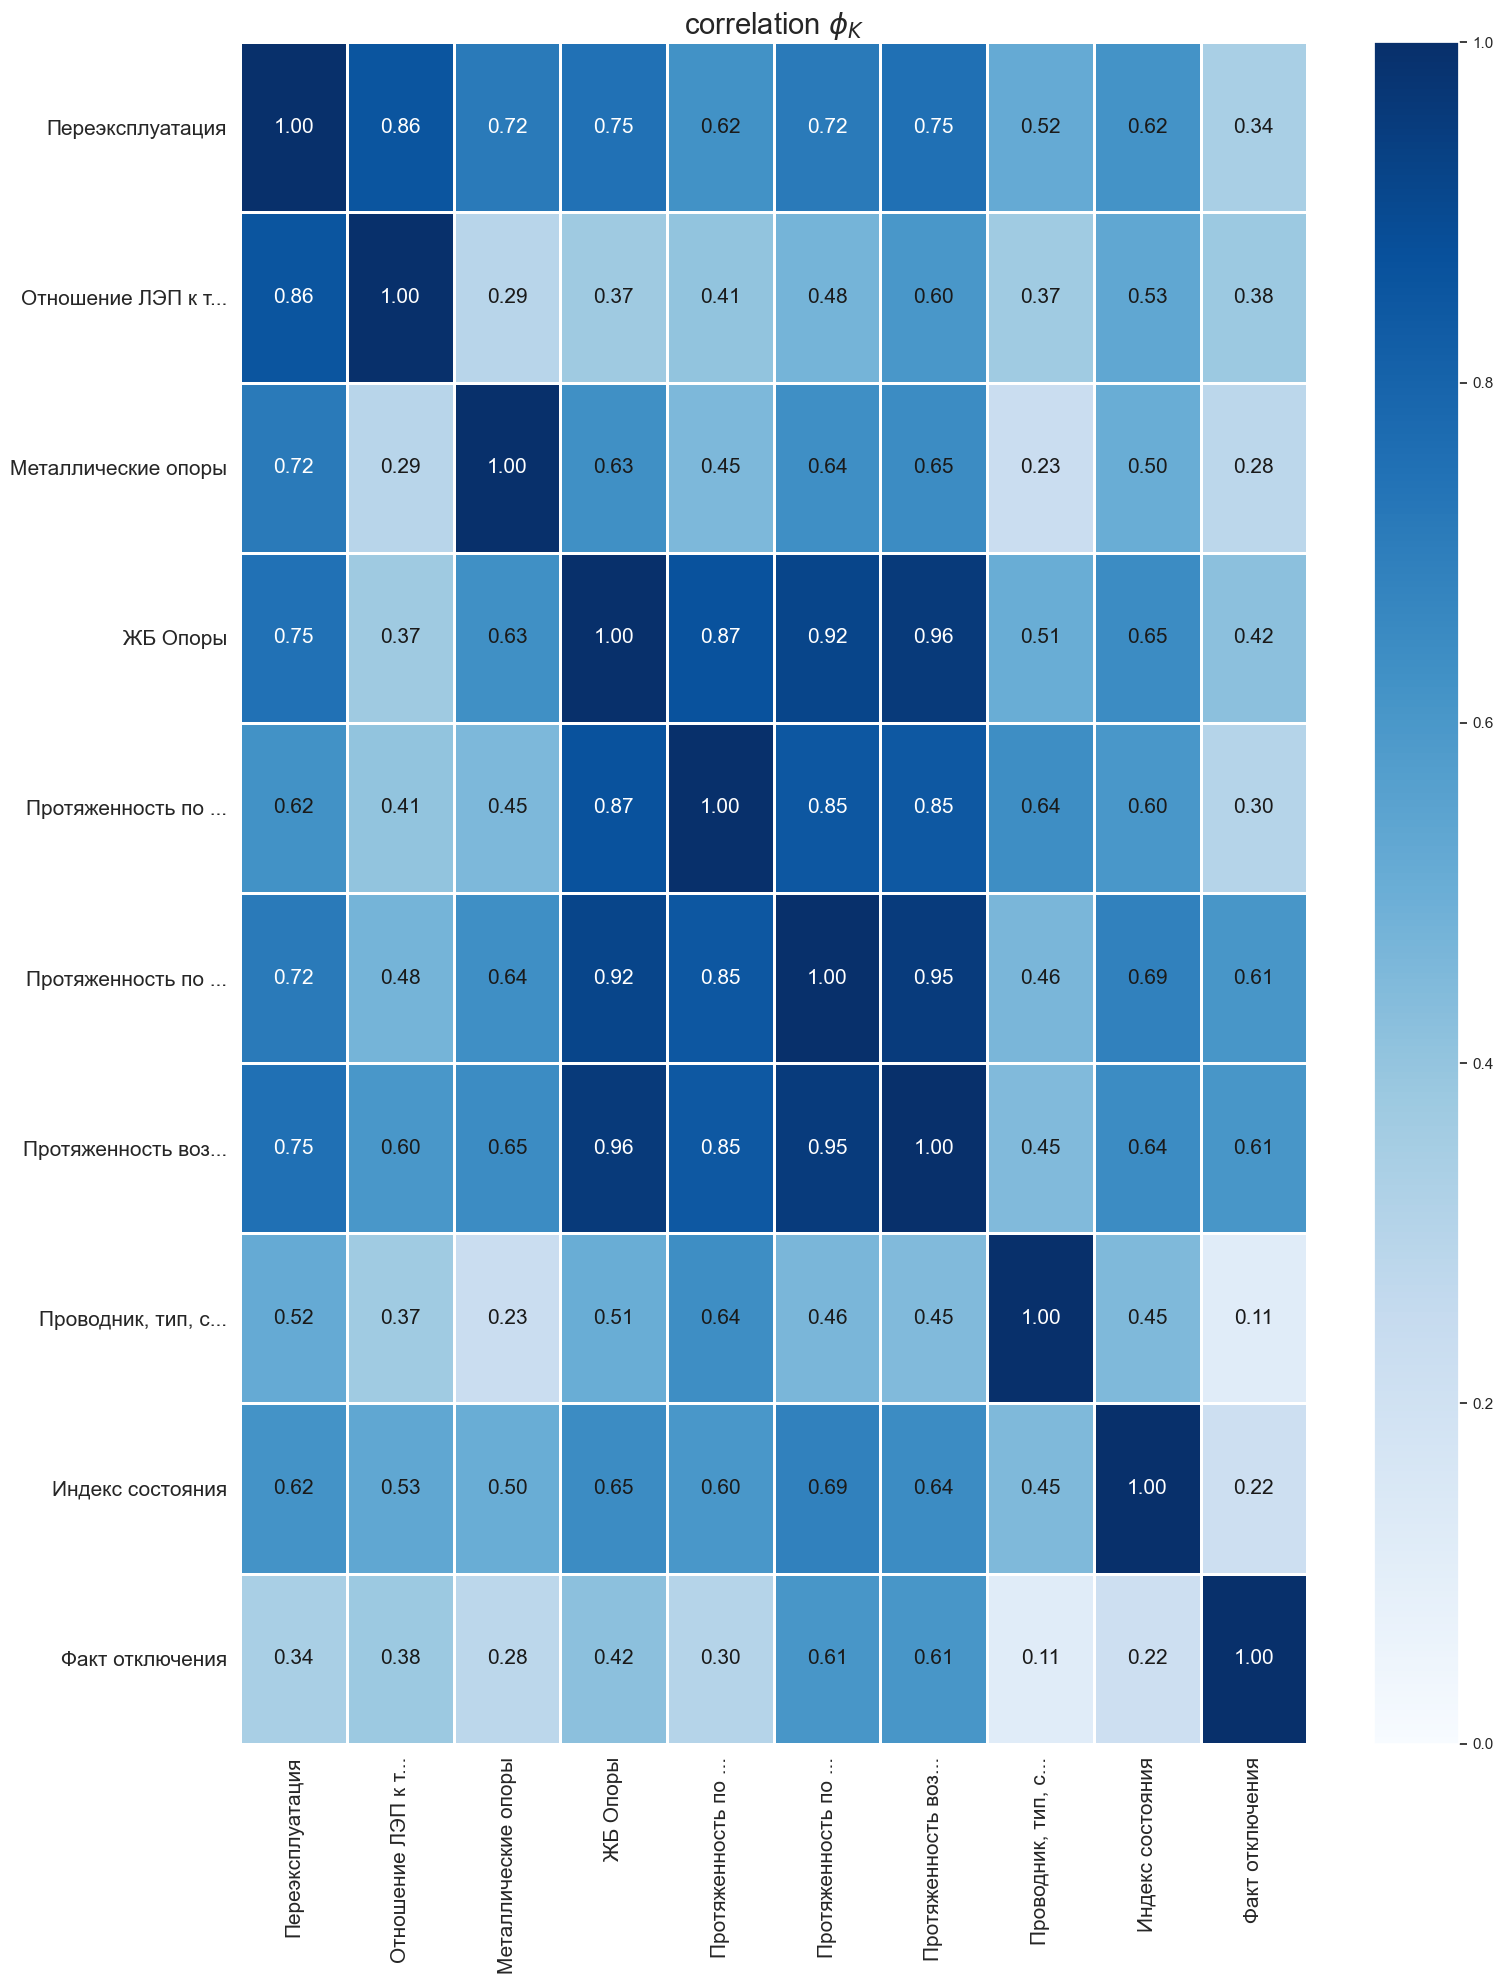

In [30]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(16,20))
plt.tight_layout()

Построенная матрица корреляции показывает, что целевой признак (Факт отключения электроэнергии) имеет слабую корреляцию с признаками. 

Матрица корреляции показывает высокую мультиколлеарность между ЖБ опорами и протяженностью, что, как описано выше, логично. Заменим абсолютные значения количества разных видов опор (железнобетонные (ЖБ), металлические) на относительные. При этом нужно учитывать, что для избежания мультиколлеарности ЖБ и металлическими опорами, нужно будет оставить только один их вид, например, ЖБ. между достаточно будет оставить Тоже самое проведем с протяженностями по лесу и по населенной местности по отношению к общей протяженности воздушных участков.

In [31]:
# Замена абсолютных значений опор на относительные
ML_df_110['ЖБ Опоры, %'] = ML_df_110['ЖБ Опоры'] /(ML_df_110['ЖБ Опоры'] + 
                                                         ML_df_110['Металлические опоры']
                                                        )

ML_df_110['Металлические опоры, %'] = ML_df_110['Металлические опоры'] /(ML_df_110['ЖБ Опоры'] + 
                                                         ML_df_110['Металлические опоры']                                                          
                                                        )
ML_df_110['Протяженность по лесу, %'] = ML_df_110['Протяженность по лесу'
                                                         ] / ML_df_110['Протяженность возд. участков']

ML_df_110['Протяженность по населенной местности, %'] = ML_df_110['Протяженность по населенной местности, км'
                                                         ] / ML_df_110['Протяженность возд. участков']



ML_df_110[['ЖБ Опоры, %',
           'Протяженность по лесу, %',
           'Протяженность по населенной местности, %'
          ]] = ML_df_110[['ЖБ Опоры, %',
                          'Протяженность по лесу, %',
                          'Протяженность по населенной местности, %'
                         ]].fillna(0)


ML_df_110 = ML_df_110.drop(['Протяженность по лесу',
                            'Протяженность по населенной местности, км',
                            'ЖБ Опоры',
                            'Металлические опоры'
                           ], axis=1)

print('Размер таблицы:', ML_df_110.shape)
ML_df_110.head()

Размер таблицы: (330, 10)


,Факт отключения,Индекс состояния,"Проводник, тип, сечение",Протяженность возд. участков,Отношение ЛЭП к транзиту,Переэксплуатация,"ЖБ Опоры, %","Металлические опоры, %","Протяженность по лесу, %","Протяженность по населенной местности, %"
0,Yes,79,АС-95,13.05,Транзитная,1.171429,0.986667,0.013333,0.506667,0.106667
1,No,79,АС-95,13.05,Транзитная,1.057143,0.986667,0.013333,0.506667,0.106667
2,No,79,АС-95,13.05,Транзитная,1.085714,0.986667,0.013333,0.506667,0.106667
3,No,79,АС-95,13.05,Транзитная,1.114286,0.986667,0.013333,0.506667,0.106667
4,No,79,АС-95,13.05,Транзитная,1.142857,0.986667,0.013333,0.506667,0.106667


In [32]:
ML_df_110 = ML_df_110.drop('Металлические опоры, %', axis=1)


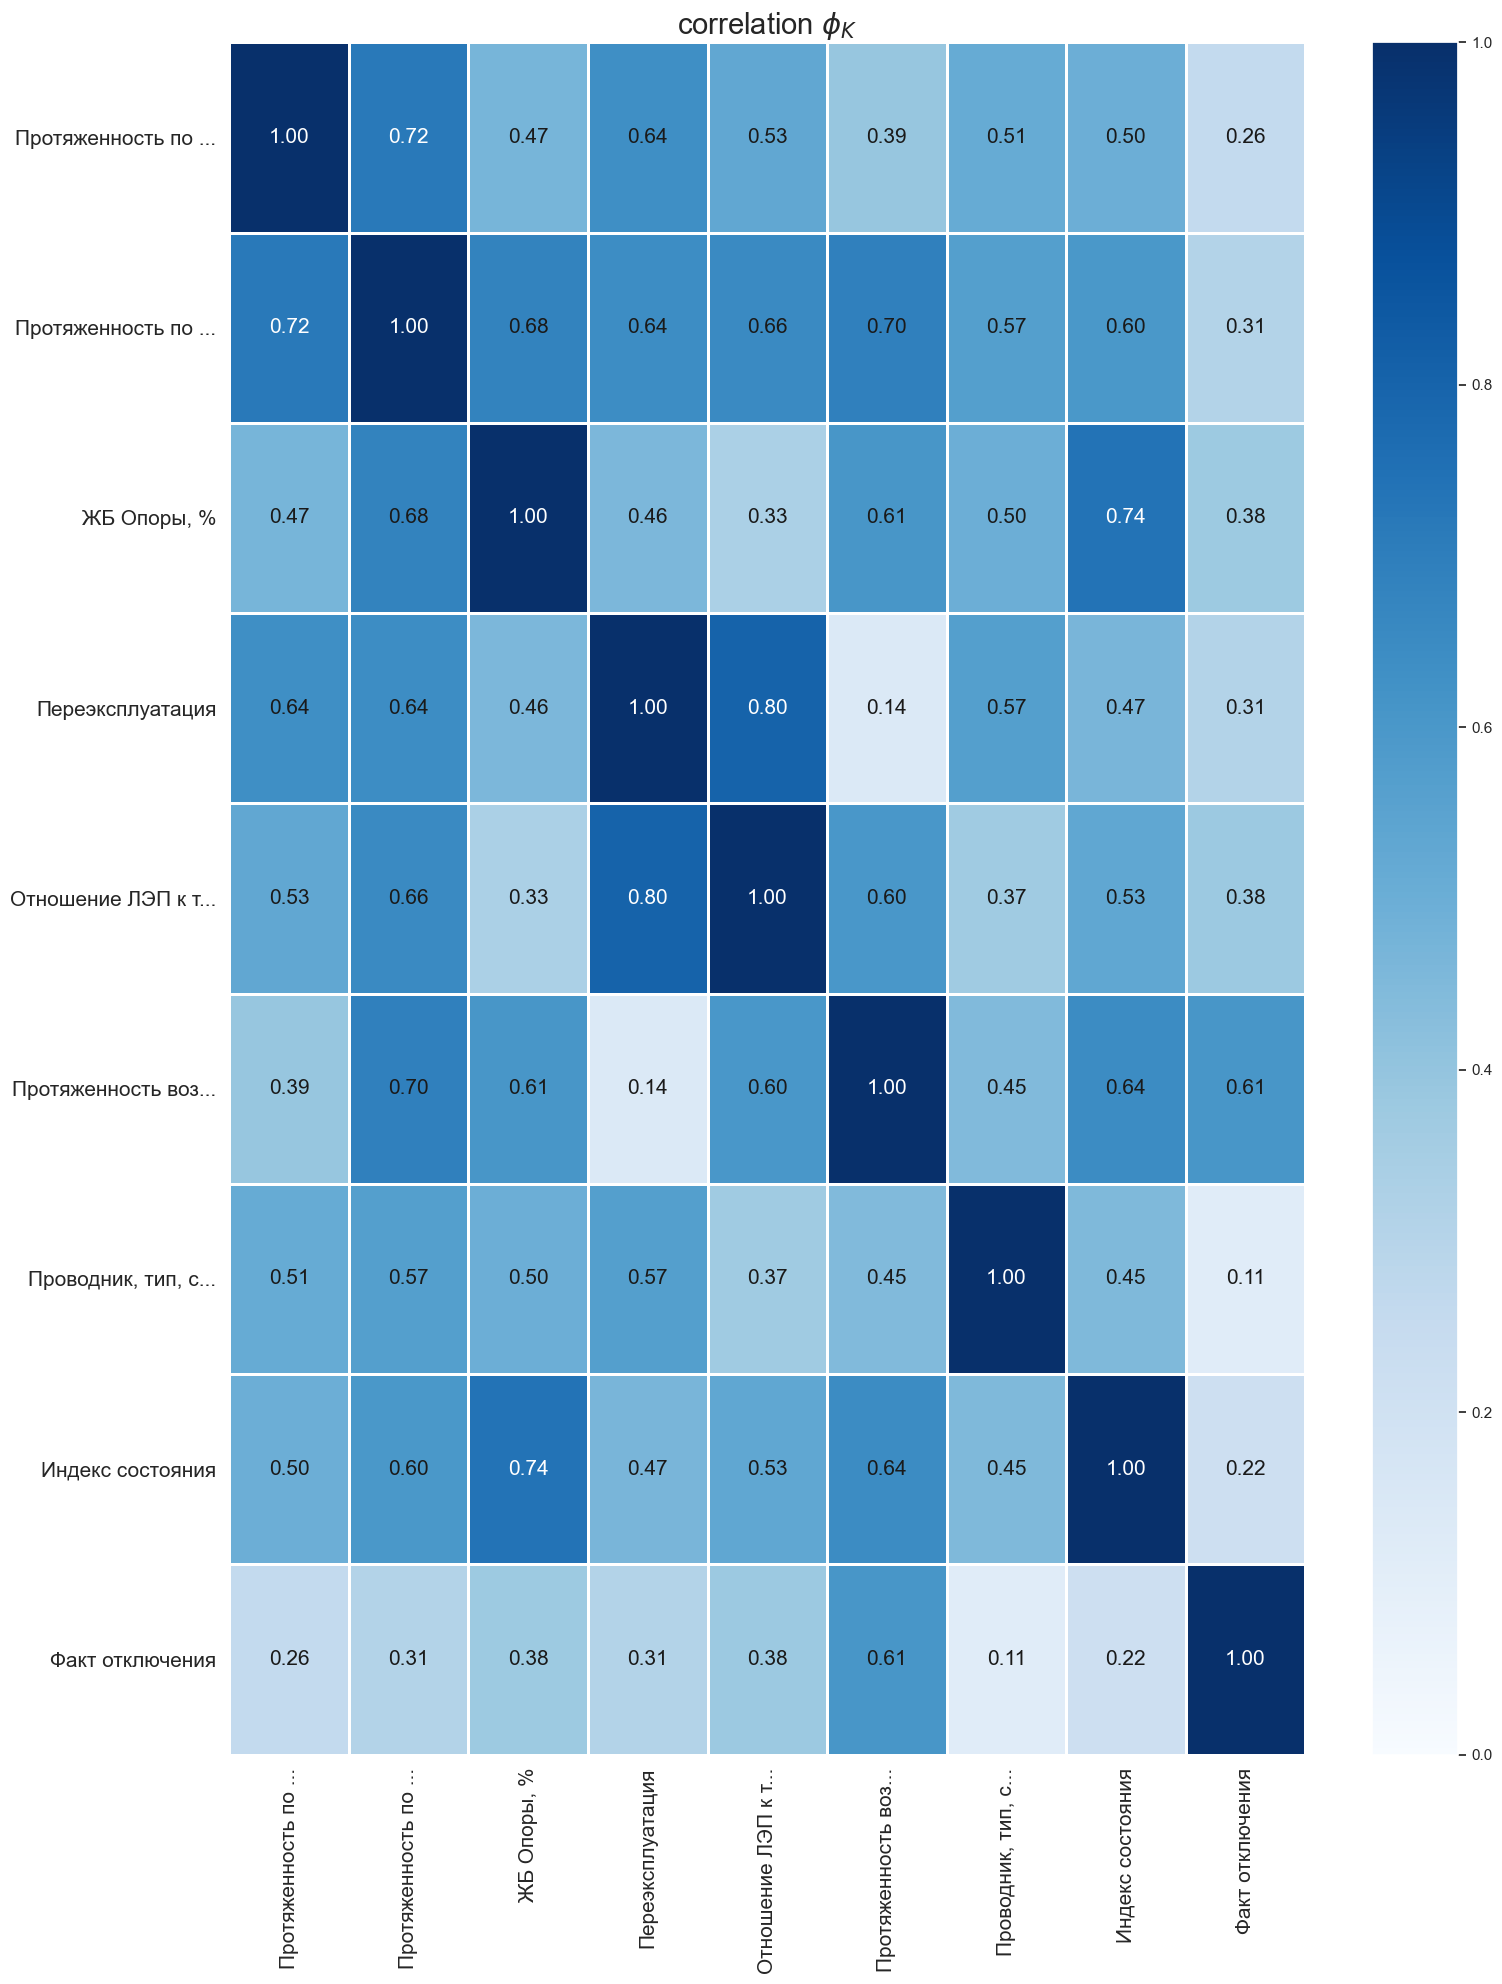

In [33]:
phik_overview = ML_df_110.phik_matrix(interval_cols=['Индекс состояния',                                                             
                                                     'Протяженность возд. участков', 
                                                     'ЖБ Опоры, %',
                                                     'Металлические опоры, %',
                                                     'Протяженность по лесу, %',
                                                     'Протяженность по населенной местности, %'                                                    
                                                     ])

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(16,20))
plt.tight_layout()

# Разработка ML моделей

## Разбиение датасета на обучающую и тестовую выборки

Определим в качестве целоевого признака столбец 'Случай_отключения':

In [34]:
target = ML_df_110['Факт отключения']
target = target.replace(['No', 'Yes'], [0, 1])
features = ML_df_110.drop(['Факт отключения'], axis=1)

Разделим признаки на обучающие и тестовые выборки в соотношении 3 к 1:

In [35]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target, shuffle = True)

print('"features_train":', features_train.shape[0],'объектов,', 
      100 - round((features.shape[0] - features_train.shape[0]) * 100 / features.shape[0]), "%" )
print('"target_train":', target_train.shape[0],'объектов,', 
      100 - round((target.shape[0] - target_train.shape[0]) * 100 / target.shape[0]), "%" )
print('"features_test":', features_test.shape[0],'объектов,', 
      100 - round((features.shape[0] - features_test.shape[0]) * 100 / features.shape[0]), "%" )
print('"target_test":', target_test.shape[0],'объектов,', 
      100 - round((target.shape[0] - target_test.shape[0]) * 100 / target.shape[0]), "%" )

"features_train": 264 объектов, 80 %
"target_train": 264 объектов, 80 %
"features_test": 66 объектов, 20 %
"target_test": 66 объектов, 20 %


## Кодирование и масштабирование признаков

Определим числовые и категориальные признаки:

In [36]:
numerical = features_train.select_dtypes(include=[np.number]).columns.tolist()
print('Числовые признаки:', numerical)
print()
categorical = features_train.select_dtypes(include='object').columns.tolist()
print('Категориальные признаки:', categorical)

Числовые признаки: ['Индекс состояния', 'Протяженность возд. участков', 'Переэксплуатация', 'ЖБ Опоры, %', 'Протяженность по лесу, %', 'Протяженность по населенной местности, %']

Категориальные признаки: ['Проводник, тип, сечение', 'Отношение ЛЭП к транзиту']


Посмотрим на кардинальность категориальных признаков:

In [37]:
for i in categorical:
    print(i,':', features[i].unique())

Проводник, тип, сечение : ['АС-95' 'АС-120' 'АС-185' 'АС-150']
Отношение ЛЭП к транзиту : ['Транзитная' 'Не транзитная']


Так как кардинальность признаков низкая рекмондуется использовать OneHotEncoder. Составим Pipiline для кодирования и масштабирования признаков:

In [38]:
numerical_transformer = StandardScaler() 
categorical_transformer_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_transformer_ord_encoder = OrdinalEncoder()

# Делаем ColumnTransformer для категориальных переменных с ohe
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer_ohe, categorical)], verbose_feature_names_out=True)


# Создадим класс для метода синтетической избыточной выборки меньшинства для номинального и непрерывного значений (SMOTE)
smote = SMOTENC(random_state=12345, categorical_features=[1, 3])

Подсчет уникальных значений показывает, что класс-меньшинство в 1,5 раза меньше класса-большинства, поэтому имеется смысл применить техники борьбы с дисбалансом. Для все моделей будем использовать параметр "взвешивания классов", а для одной из лучших попробуем технику создания синтетических объектов SMOTE для сравнения полученной метрики.

In [39]:
# Создадим класс для метода синтетической избыточной выборки меньшинства для номинального и непрерывного значений (SMOTE)
smote = SMOTENC(random_state=12345, categorical_features=[1, 3])

## Выбор и обучение моделей машинного обучения на кросс-валидации

Для обучения выбрем следующие модели:

- LogisticRegression,
- RandomForestClassifier,
- LightGBM Classifier,
- CatBoostClassifier.

Обучение и оценка моделей будет производится через перекрестную проверку с использованием 3 блоков для кросс-валидации.

### LogisticRegression 

In [40]:
%%time

#  Составляем pipeline:

pipeline_LR = Pipeline([
    ('preprocessor_ohe', preprocessor_ohe),
    ('model_LR', LogisticRegression(random_state=12345,
                                    penalty='elasticnet',
                                    solver='saga',
                                    class_weight='balanced'))
])

param_grid = {'model_LR__C': range(1,15,2),  
              'model_LR__l1_ratio': np.arange(0, 1, 0.2)}


tuning_model_LR = RandomizedSearchCV(pipeline_LR,
                                      param_grid, 
                                      cv=3, 
                                      n_jobs=-1, 
                                      scoring='roc_auc', 
                                      verbose=0,
                                      n_iter=50,
                                      random_state=140823,
                                     )

tuning_model_LR.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_LR.best_score_,2)},\
достигается при параметрах: {tuning_model_LR.best_params_}")  

Наилучшая метрика 'roc_auc', равная 0.76,достигается при параметрах: {'model_LR__l1_ratio': 0.6000000000000001, 'model_LR__C': 1}
CPU times: total: 312 ms
Wall time: 1.58 s


### RandomForestClassifier

In [41]:
%%time

#  Составляем pipeline:

pipeline_RFC = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_RFC', RandomForestClassifier(random_state=123456,
                                         class_weight='balanced'))
])

param_grid = {
    'model_RFC__n_estimators': range (100, 1000, 100),
    'model_RFC__max_depth': range (1,21, 21),
    'model_RFC__min_samples_leaf': range (2,50,10),
    'model_RFC__min_samples_split': range (2,50,10)}

tuning_model_RFC = RandomizedSearchCV(pipeline_RFC,
                                      param_grid, 
                                      cv=3, 
                                      n_jobs=-1, 
                                      scoring='roc_auc', 
                                      verbose=1,
                                      n_iter=100,
                                      random_state=12345,
                                     )


tuning_model_RFC.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_RFC.best_score_,2)},\
достигается при параметрах: {tuning_model_RFC.best_params_}")  

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Наилучшая метрика 'roc_auc', равная 0.78,достигается при параметрах: {'model_RFC__n_estimators': 200, 'model_RFC__min_samples_split': 22, 'model_RFC__min_samples_leaf': 32, 'model_RFC__max_depth': 1}
CPU times: total: 1.55 s
Wall time: 1min 49s


### LGBMClassifier

In [42]:
%%time

pipeline_LGBM = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_LGBM', LGBMClassifier(random_state=12345,
                                  class_weight='balanced'))
])

param_grid = {'model_LGBM__learning_rate': np.arange(0.01, 0.21, 0.05),
              'model_LGBM__max_depth': np.arange(1, 15, 1),
              'model_LGBM__n_estimators': range (10, 1000, 10)}


tuning_model_LGBM = RandomizedSearchCV(pipeline_LGBM,
                                      param_grid, 
                                      cv=3, 
                                      n_jobs=-1, 
                                      scoring='roc_auc', 
                                      verbose=1,
                                      n_iter=100,
                                      random_state=12345
                                     )


tuning_model_LGBM.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_LGBM.best_score_,2)},\
достигается при параметрах: {tuning_model_LGBM.best_params_}")  

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Number of positive: 108, number of negative: 156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 264, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Наилучшая метрика 'roc_auc', равная 0.78,достигается при параметрах: {'model_LGBM__n_estimators': 900, 'model_LGBM__max_depth': 1, 'model_LGBM__learning_rate': 0.01}
CPU times: total: 1.69 s
Wall time: 30.2 s


### CatBoostClassifier

In [43]:
%%time

classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

pipeline_CBС = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_CBC', CatBoostClassifier(random_state=12345, class_weights=class_weights))
])

param_grid = {
    'model_CBC__depth': np.arange(1, 10, 1),
    'model_CBC__learning_rate':  [0.0001, 0.001, 0.01],
    'model_CBC__iterations':  range(10, 150, 10),
    'model_CBC__l2_leaf_reg': np.arange(1, 15, 1)
}


tuning_model_CBС = RandomizedSearchCV(pipeline_CBС,
                                      param_grid, 
                                      cv=3, 
                                      n_jobs=-1, 
                                      scoring='roc_auc', 
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345
                                     )
tuning_model_CBС.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_CBС.best_score_,2)},\
достигается с взвешиванием классов при параметрах: {tuning_model_CBС.best_params_}") 

Наилучшая метрика 'roc_auc', равная 0.79,достигается с взвешиванием классов при параметрах: {'model_CBC__learning_rate': 0.001, 'model_CBC__l2_leaf_reg': 13, 'model_CBC__iterations': 100, 'model_CBC__depth': 4}
CPU times: total: 1.73 s
Wall time: 27.4 s


In [44]:
pipeline_CBС_smote = Pipeline_smote([
    ("smote", smote),
    ("preprocessor_ohe", preprocessor_ohe),    
    ('model_CBC', CatBoostClassifier(random_state=12345))
])

param_grid = {
    'model_CBC__depth': np.arange(1, 10, 1),
    'model_CBC__learning_rate':  [0.0001, 0.001, 0.01],
    'model_CBC__iterations':  range(10, 150, 10),
    'model_CBC__l2_leaf_reg': np.arange(1, 15, 1)
}
tuning_model_CBС_smote = RandomizedSearchCV(pipeline_CBС_smote,
                                            param_grid, 
                                            cv=3, 
                                            n_jobs=-1, 
                                            scoring='roc_auc', 
                                            verbose=1,
                                            n_iter=100,
                                            random_state=12345
                                           )

tuning_model_CBС_smote.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_CBС_smote.best_score_,2)},\
достигается со SMOTE при параметрах: {tuning_model_CBС_smote.best_params_}") 

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Наилучшая метрика 'roc_auc', равная 0.79,достигается со SMOTE при параметрах: {'model_CBC__learning_rate': 0.0001, 'model_CBC__l2_leaf_reg': 7, 'model_CBC__iterations': 50, 'model_CBC__depth': 3}


## Выбор лучшей модели по метрике ROC-AUC на кросс-валидации

In [45]:
total = [["LogisticRegression:  ", round(tuning_model_LR.best_score_,3)],
         ["RandomForestClassifier: ", round(tuning_model_RFC.best_score_,3)],
         ["LightGBMClassifier:  ", round(tuning_model_LGBM.best_score_,3)],
         ["CatBoostClassifier:  ", round(tuning_model_CBС.best_score_,3)],
         ["CatBoostClassifier with smote:", round(tuning_model_CBС_smote.best_score_,3)]
        ]
total= pd.DataFrame(total, columns=["модель","ROC-AUC"])
total = total.set_index('модель')
total.index.names = [None]

total.sort_values(by = "ROC-AUC", ascending = False)

,ROC-AUC
CatBoostClassifier:,0.790
CatBoostClassifier with smote:,0.789
RandomForestClassifier:,0.782
LightGBMClassifier:,0.782
LogisticRegression:,0.765


Лучшая метрика ROC-AUC со значением 0,79 была достигнута у модели CatBoostClassifier при гиперпараметрах:

- 'model_CBC__learning_rate': 0.001,
- 'model_CBC__l2_leaf_reg': 13, 
- 'model_CBC__iterations': 100, 
- 'model_CBC__depth': 4

In [46]:
best_model = tuning_model_CBС

# Оценка качества модели на тестовой выборке

## ROC-AUC и ROC-кривая

Проверим лучшую модель (CatBoostClassifier) на тестовой выборке:

In [47]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test,probabilities_one_test, average=None)
print('Метрика ROC-AUC наилучшей модели равна', round(auc_roc,2))

Метрика ROC-AUC наилучшей модели равна 0.79


Построим ROC-кривую для лучшей модели и изобразите её на графике:

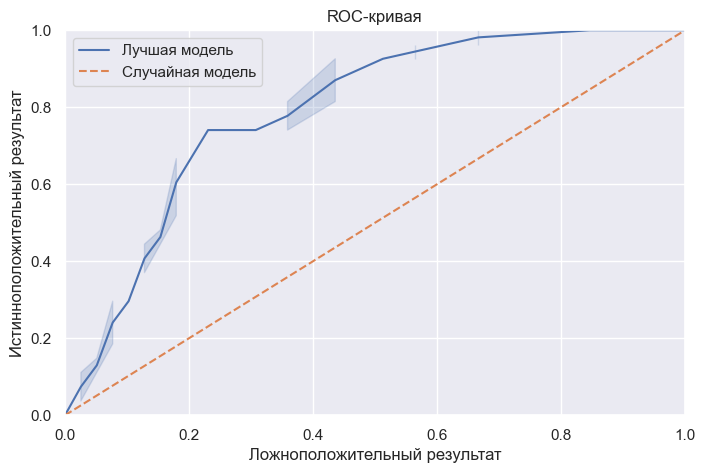

In [48]:
# Определим долю ложноположительных ответов (FPR) и истинно положительных ответов (TPR) лучшей модели:

fpr, tpr, thresholds = roc_curve(target_test,probabilities_one_test) 

# ROC-кривая лучшей модели:
plt.figure(figsize=(8, 5))
sns.lineplot(x=fpr, y=tpr, label="Лучшая модель")

# ROC-кривая случайной модели: 
sns.lineplot(x=[0, 1], 
             y=[0, 1], 
             linestyle='--', label="Случайная модель")\
.set(xlabel='Ложноположительный результат', 
     ylabel='Истинноположительный результат',  
     title = 'ROC-кривая')

plt.xlim(0,1) 
plt.ylim(0,1)
plt.legend()
plt.show()

На графике по горизонтали показана доля ложноположительных ответов (False Positive Rate), по вертикали - доля истинно положительных ответов (True Positive Rate). Для модели, которая всегда отвечает случайно, ROC-кривая представлена прямой оранжевой пунктирной линией. Касательно качества модели на графике, если модель не делает ошибок, то кривая будет стремиться к точке (0.0,1.0), в противном случае, AUC-ROC стремиться к 0.5, то есть случайно выдавать вероятность классов. Полученная площадь под кривой метрика AUC-ROC в 0.79 говорит о том, что рассматриваемая модель неплохо предсказывает значения.

## Accuracy

In [49]:
predictions = best_model.predict(features_test)
print('Метрика Accuracy наилучшей модели равна', round(accuracy_score(target_test, predictions),4))

Метрика Accuracy наилучшей модели равна 0.7121


Accuracy показывает отношение количества правильных прогнозов к их общему количеству. Accuracy лучшей модели, равная 0.8404, означает, что модель с точностью 85,29% делает верный прогноз.

## Матрица ошибок

Наглядно представить результаты вычислений метрик точности и полноты позволяет матрица ошибок. Матрица ошибок формируется следующим образом: по диагонали от верхнего левого угла выстроены правильные прогнозы, вне главной диагонали — ошибочные варианты и содержит:
- Истинно отрицательные ответы (True Negative) в левом верхнем углу,
- Истинно положительные ответы (True Positive) в правом нижнем углу,
- Ложноположительные ответы (False Positive) в правом верхнем углу,
- Ложноотрицательные ответы (False Negative) в левом нижнем углу.

In [50]:
cm = confusion_matrix(target_test,predictions)
cm

array([[25, 14],
       [ 5, 22]], dtype=int64)

Визуализируем матрицу ошибок:

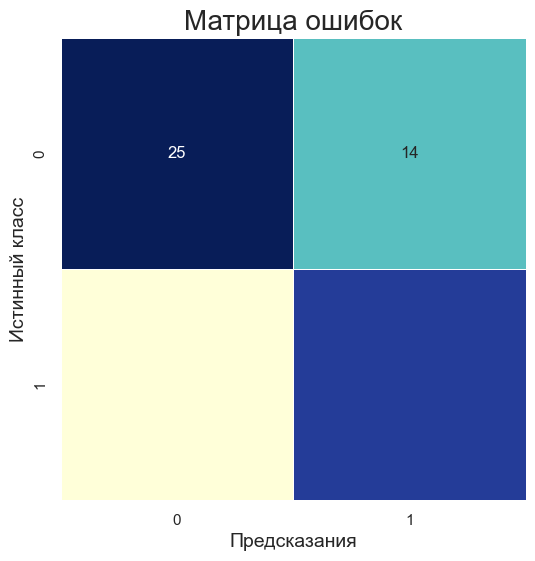

In [51]:
plt.figure(figsize=(6, 6))

sns.heatmap(cm, annot=True, linewidth=.5, fmt=".0f", cbar=False, cmap="YlGnBu")
plt.title("Матрица ошибок", fontsize=20)
plt.xlabel('Предсказания', fontsize=14)
plt.ylabel('Истинный класс', fontsize=14)
plt.show()

Цель задачи состоит в максимизации истинно положительных и истинно отрицательных ответов и минимизации ложноположительных и ложноотрицательных ответов. Лучшая модель CatBoostClassifier выдает 52 истинно положительных и 6 истинно отрицательных ответов, при этом на долю ложных приходится 1 положительных и 9 отрицательных ответов соответственно.

## Проверка на адекватность

Проверим модель на адекватность путем сравнения полученнных значений метрик с контрольными константной модели DummyClassifier со стратегией классфикации “most_frequent”, генерирующей предсказания наиболее часто встречаемого класса.

In [59]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)

probabilities_test_dummy = dummy_clf.predict_proba(features_test)
probabilities_one_test_dummy = probabilities_test_dummy[:, 1]

auc_roc_dummy = roc_auc_score(target_test,probabilities_one_test_dummy, average=None)

predictions_dummy = dummy_clf.predict(features_test)
accuracy_dummy = accuracy_score(target_test, predictions_dummy)

print("Accuracy  константной модели DummyClassifier равна:", round(accuracy_dummy,3))
print('Метрика ROC-AUC константной модели DummyClassifier равна', round(auc_roc_dummy,3))

Accuracy  константной модели DummyClassifier равна: 0.591
Метрика ROC-AUC константной модели DummyClassifier равна 0.5


Используя модель DummyClassifier, можно сделать вывод, что выбранная модель машинного обучения проходит проверку на адекватность, так как её метрики значительно уступают метрикам лучшей модели. Метрика ROC-AUC константной модели DummyClassifier составила 0.5 против 0.79 у лучшей модели, 
Accuracy-  0.59 против 0.71..

#  Важность признаков

Рассмотрим важность признаков у модели CatBoostClassifier и оценочные коэффициенты LogisticRegression.

In [85]:
feature_importance = [best_model.best_estimator_[0].transformers_[0][2] + best_model.best_estimator_[0].transformers_[1][1].get_feature_names_out(categorical).tolist(),
          list(best_model.best_estimator_[1].feature_importances_), list(tuning_model_LR.best_estimator_[1].coef_[0])]
         
feature_importance = pd.DataFrame(feature_importance).transpose()
feature_importance.columns =['Признаки', 'Важность_CBC','Коэффициенты_LR']

feature_importance = feature_importance.set_index('Признаки', drop=True).sort_values(by='Важность_CBC', ascending=False)
feature_importance

,Важность_CBC,Коэффициенты_LR
Признаки,,
Протяженность возд. участков,66.471091,0.841323
"ЖБ Опоры, %",12.497292,0.120706
Отношение ЛЭП к транзиту_Не транзитная,6.444073,-0.602725
Отношение ЛЭП к транзиту_Транзитная,5.474285,0.535547
"Протяженность по лесу, %",2.619971,0.114524
Индекс состояния,2.100727,0.0
"Протяженность по населенной местности, %",1.991004,-0.354118
Переэксплуатация,1.031832,0.025443
"Проводник, тип, сечение_АС-120",0.412851,0.254625


Визуализируем таблицу:

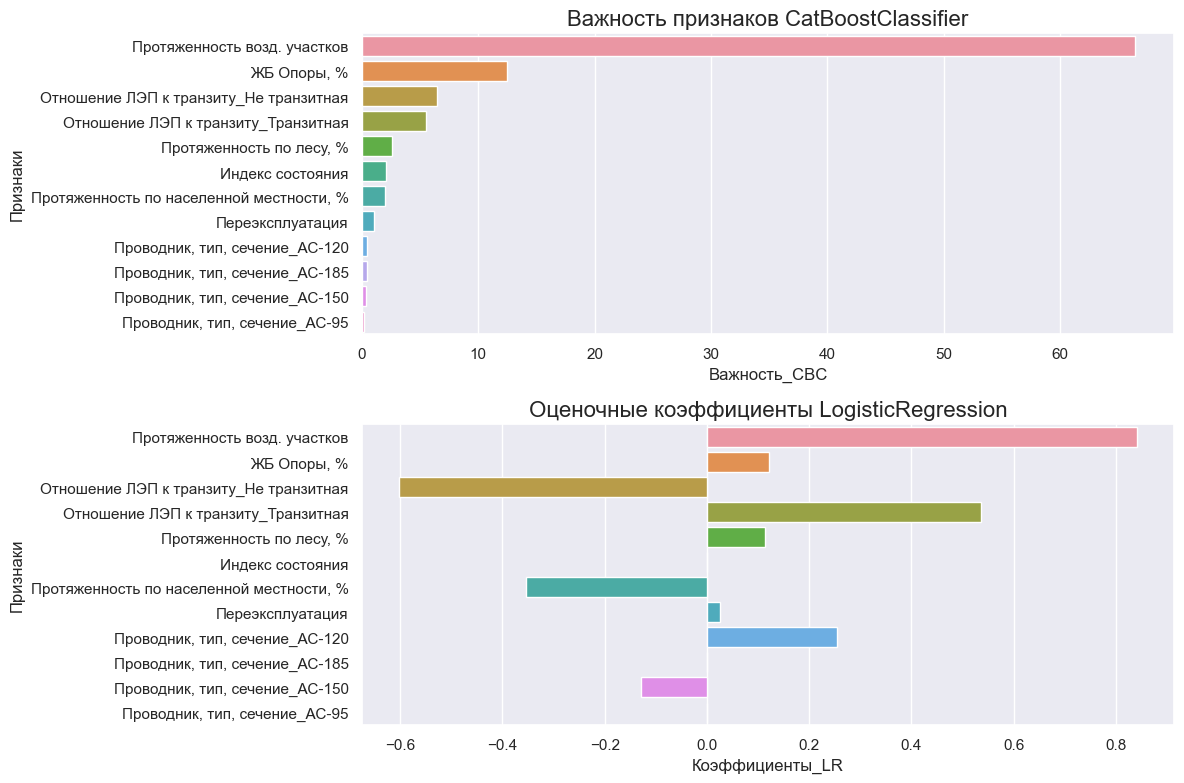

In [99]:
pic_box = plt.figure(figsize=(12,8))
pic_box.add_subplot(2,1,1)
sns.barplot(feature_importance, y = feature_importance.index, x = 'Важность_CBC')
plt.title('Важность признаков CatBoostClassifier', fontsize = 16)
pic_box.add_subplot(2,1,2)
sns.barplot(feature_importance, y = feature_importance.index, x = 'Коэффициенты_LR')
plt.title('Оценочные коэффициенты LogisticRegression', fontsize = 16)
plt.tight_layout() 

Наибольшее влияние на прогнозирование моделей ожидаемо составил признак "Протяженность воздушных участков" (66 % для CatBoostClassifier, коэффицент для LogisticRegression - 0,84), так как известно, что чем больше длина ЛЭП, тем больше внешних факторо, способных на ЛЭП оказывать влияние. Большое влияние на прогнозирвание моделей оказывает отнесение высоковольных линий к транзитным ЛЭП или нет (6% и 5%, соотвественнно, для CatBoostClassifier), при этом, если ЛЭП транзитная, то вероятноятность ожидания отключений электроэнергии резко возрастает, если не транзитная - то наоборот. Эта особенность хорошо видна на моделе логистической регрессии - (коэффициенты равны 0,5 и -0,6 соответсвенно). Также влияние на прогноз оказывают  количество ЖБ опор и протяженность по лесу (лесные массивы вызывают большую вероятность отключений, например, перекрытие проводов ветвями деревьев).

# Выводы

**Подготовка данных**

Были изучены и предварительно проанализированы представленные данные по отключениям электроэнергии в электрических сетях Орловской области.

В наличии имеется три датасета: 
1. События отключения электроэнергии с 1 января 2018 по 14 октября 2021. Вид технологического отключения: Аварийное, Неотложное, Плановое, Неплановое, Потребительское, Ограничения 
2. События отключения электроэнергии с 1 января 2021 г. по 31 декабря 2022 г. Вид технологического отключения: Аварийное.
3. Информация о линиях электропередачи 35 и 110 кВ

Таблицы с данными по событиям отключений электроэнергии были объединены, образовавшиеся дубликаты удалены. Количество строк в объединенном датасете составило 28455 шт. На основе полученного датасета и данных по ВЛ 35 и 110 кВ, были выведены таблицы так, чтобы на каждую ЛЭП по годам были посчитаны количество отключений и продолжительность этих отключений. Для поставленной цели, было решено работать только с сетями 110 кВ из-за наличия большего количества объектов для обучения моделей.

**Обработка данных**

Были созданы 2 синтетических признака ("факт отключения", "переэксплуатация"), подправлена точность признака "срок эксплуатации ЛЭП", заменены необходимые типы данных.  В качестве целевого признака решено использовать "Факт отключения". Был проведен EDA признаков, в ходе которого было решено удалить признаки "Тип", 'Длина кабельных\n участков', "Чистое дерево", "На ЖБ пасынках" из-за малого количества значений. 

Была построена матрица корреляции с помощью библиотеки phik, показавшая, что целевой признак (Факт отключения электроэнергии) имеет слабую корреляцию с остальными признаками. и высокую мультиколлеарность между ЖБ опорами и протяженностью. Было решено заменить абсолютные значения количества разных видов опор (железобетонные (ЖБ), металлические) на относительные. Также из-за высокой мультиколлеарности было решено перевести в относительные значения протяженности по лесу и по населенной местности по отношению к общей протяженности воздушных участков. 

Итоговый датасет состоял из 330 объектов и 10 признаков, включая целевой признак. Пропущенных значений нет.

**Разработка ML моделей**

Датасет признаков разделен на обучающие и тестовые выборки в соотношении 4 к 1. Составлен Pipiline для кодирования и масштабирования признаков, при чем было решено использовать OneHotEncoder из-за низкой кардинальность категориальных признаков. В качестве масштабирования использовался StandardScaler. Так как присутствовал небольшой дисбаланс классов, для все моделей использовался параметр "взвешивания классов", а для одной из лучших была опробована техника создания синтетических объектов SMOTE, также включенная в Pipiline. Для обучения были выбраны следующие модели: LogisticRegression, RandomForestClassifier, LightGBM Classifier, CatBoostClassifier. 

Обучение и оценка моделей производилась через перекрестную проверку с использованием 3 блоков для кросс-валидации. Модель CatBoostClassifier оказалась наиболее точной по метрике ROC-AUC со значением 0.79, при этом использование SMOTE техники для балансировки классов снизило значение метрики до 0,789. Худший результат показала модель линейной регрессии - 0,765.

В качестве лучшей выбрана модель CatBoostClassifier с параметрами: гиперпараметрами'model_CBC__learning_rate': 0.001, 'model_CBC__l2_leaf_reg': 13, 'model_CBC__iterations': 100, 'model_CBC__depth': 4.

**Оценка качества модели на тестовой выборке**

Модель CatBoostClassifier проверена на тестовой выборке, метрика ROC-AUC составила 0.79. Дополнительно построена ROC-кривая для модели. Посчитана доля правильных ответов Accuracy, составившая 0.71 и построена матрица ошибок. Согласно матрице ошибок, модель CatBoostClassifier выдает 22 истинно положительных и 25 истинно отрицательных ответов, при этом на долю ложных приходится 14 положительных и 5 отрицательных ответов соответственно. 

Модель CatBoostClassifier прошла проверку на адекватность путем сравнения полученных значений метрик с контрольными константной модели DummyClassifier со стратегией “most_frequent”, генерирующей предсказания наиболее часто встречаемого класса. Метрика ROC-AUC константной модели DummyClassifier составила 0.5 против 0.79 у лучшей модели, Accuracy - 0.59 против 0.71.

**Важность признаков**

Рассмотрена важность признаков у модели CatBoostClassifier и оценочные коэффициенты LogisticRegression. Наибольшее влияние на прогнозирование моделей ожидаемо составил признак "Протяженность воздушных участков" (66 % для CatBoostClassifier, коэффициент для LogisticRegression - 0,84), так как известно, что чем больше длина ЛЭП, тем больше внешних факторов, способных на ЛЭП оказывать влияние. Большое влияние на прогнозирование моделей оказывает отнесение высоковольтных линий к транзитным ЛЭП или нет (6% и 5%, соответственно, для CatBoostClassifier), при этом, если ЛЭП транзитная, то вероятность ожидания отключений электроэнергии резко возрастает, если не транзитная - то наоборот. Эта особенность хорошо видна на модели логистической регрессии - (коэффициенты равны 0,5 и -0,6 соответственно). Также влияние на прогноз оказывают количество ЖБ опор и протяженность по лесу (лесные массивы вызывают большую вероятность отключений, например, перекрытие проводов ветвями деревьев).

**Рекомендации**

Выбранная модель машинного обучения LightGBMClassifier эффективно справляется с поставленной задачей прогнозирования возможных отключений электроэнергии на линиях электропередачи (110 кВ) на основе характеристик самих ЛЭП со значением метрики ROC-AUC в 0.79. Для повышения точности рекомендуется увеличение выборки, за счет списка отключений электроэнергии до 2018. Также для разработки модели прогнозирования отключений электроэнергии на линиях электропередачи меньшего напряжения (10 кВ, 6 кВ и/или 0,4 кВ), рекомендуется предоставить соответствующую информацию по их характеристикам.

Так как модель имеет достаточно точное прогнозирование, то представители РЭС, используя модель, могут точечно реконструировать ЛЭП, наиболее подверженные к перерывам в электроснабжении. При этом согласно рассмотренным выше признакам, ранжированных по важности, самая эффективная мера — это приведение потяженности ЛЭП к нормативным значениям.
) и межсетевого экрана (3).

%%capture
!pip install nbconvert
import nbconvert

%%capture
!jupyter nbconvert outages-2d_part.ipynb --to pdf --TemplateExporter.exclude_input=True